https://www.gdal.org/gdal_retile.html



## Import

In [5]:
import pandas as pd
import geopandas # http://geopandas.org/reference.html
import matplotlib.pyplot as plt

import glob


import os
import shutil     # Kopiering av filer
from osgeo import ogr, gdal    # GDAL

# Python kode som delar opp bildet.
import gdal_retile

In [7]:
# Check that unpacked files are there. Unpack them?
!ls ../Raw_data

20180705-biri_03_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.zip
20180705-biri_03_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.zip
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.hdr
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.zip
20180705-biri_13_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.zip
laserdata.zip


In [8]:
# Global variables:
name_imagefiles= glob.glob('../Raw_data/*.dat') # Lists every imagefile
#ame_shapefile = "shapefile/utsnit.shp"
name_csv = 'tile_envelope_coordinates.csv'
in_directory = '../Sorted_tiles'
out_directory = '../Sorted_tiles/mis_tiles'

# Size of output tile
tile_with = '256'
tile_heigth = '256'

## Make tiles

In [9]:
# Run retilefunction for each image
for i, image_name in enumerate(name_imagefiles):
    print(f'Prossesing image {i+1} of {len(name_imagefiles)}')
    
    cmd = 'gdal_retile.py -ps ' + tile_with +' '+ tile_heigth + ' -overlap 0 -levels 1 -r near -ot Float32 -csv '+ str(i) + name_csv + ' -csvDelim "," -targetDir '+'\''+in_directory+'\''+ ' ' +'\''+image_name+'\''
    #print(cmd)
    os.system(cmd)

Prossesing image 1 of 1


## Find categories

In [16]:
MIS_code_key = pd.read_excel(io='../Prosjekt_Honne_data_Landbruksdirektoratet/Koder Mis-nin i shape pilot 2.0.xlsx', sheet_name='LM.kode')
MIS_code_key

,Kode,Navn
0,1,Stående død ved
1,2,Liggende død ved
2,3,Rikbarkstrær
3,4,Trær med hengelav
4,5,Eldre lauvsuksesjoner
5,6,Gamle trær
6,7,Hule lauvtrær
7,8,Brannflater
8,9,Rik bakkevegetasjon
9,10,Bergvegger


In [17]:
# Read mis-polygons
mis_geometry = geopandas.read_file('../Prosjekt_Honne_data_Landbruksdirektoratet/Leveranse_MiS_201017_Mjosen/MiS_NiN_Biri_Mjosen_2017.shp')
mis_geometry.head()

,OBJECTID,AREAL,REG_DATO_F,KGRAD,VERDI,NATURTYPE,KGRAD_BEGR,SKOGBESKRI,FORVALTNIN,FKODE,...,UT_EKSP,KI_VANNP,LIVSM1,LIVSM2,area,sum_lauv,sum_gamle,sum_LDV,sum_SDV,geometry
0,0,8,2017-09-01,0,None,0,None,Ensjiktet produksjonsskog av gran og noe bjørk...,None,1,...,b,A2,2,1,8159,0,0,19,16,"POLYGON ((585266.8620801514 6754440.302978287,..."
1,0,2,2017-09-01,0,None,0,None,Gamle furutrr I blanding med gran og noe lauv.,None,1,...,d,A2,6,0,2251,0,7,0,0,"POLYGON ((585548.5608584847 6754543.789799314,..."
2,0,3,2017-09-12,0,None,0,None,Bekkeklöft med noe liggende død ved og hengestry.,None,1,...,a,A2,12,2,3235,0,0,15,0,"POLYGON ((586009.7207604215 6754258.584550213,..."
3,0,3,2017-09-12,0,None,0,None,Liggende og noe stående død ved.,None,1,...,a,A2,2,0,2871,0,0,10,0,"POLYGON ((586245.598938267 6754403.08832045, 5..."
4,0,9,2017-09-13,0,None,0,None,Også noe stående død ved.,None,0,...,b,A2,2,0,9474,0,0,14,0,"POLYGON ((587132.3176386385 6754551.368164727,..."


## Sort tiles

In [104]:
# Merge all csv files to one big
all_files = glob.glob(os.path.join(in_directory, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, names = ["Tile_name", "X_ul", "X_lr", "Y_ul", "Y_lr"]) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [109]:
# Read mis-polygons
mis_geometry = geopandas.read_file('../Qgis/test_polygon/testpolygon.shp')
mis_geometry.head()

,id,geometry
0,1,"POLYGON ((583606.7441549296 6755460.284718311,..."
1,2,"POLYGON ((586039.8219014085 6755367.182253523,..."
2,3,"POLYGON ((582998.4747183099 6756205.104436621,..."


<Figure size 432x288 with 0 Axes>

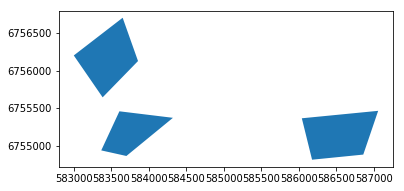

In [97]:
# Plot mis-polygons
plt.figure()
mis_geometry.plot()
plt.show()

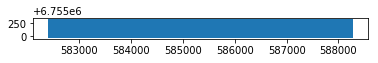

In [149]:
# Create a geometry of every tile (bounding box)
# https://gis.stackexchange.com/questions/285336/convert-polygon-bounding-box-to-geodataframe
b = [geopandas.base.box(l, b, r, t) for l, b, r, t in zip(concatenated_df.X_ul, concatenated_df.Y_lr, concatenated_df.X_lr, concatenated_df.Y_ul)]

gdf = geopandas.GeoDataFrame(concatenated_df, geometry=b)

In [191]:
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for polygon_num, polygon in enumerate(mis_geometry.geometry):
    print(f'Checking polygon {polygon_num + 1} of {len(mis_geometry.geometry)}')
    
    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():
        
        # If tile is inside, sort it into folder
        if polygon.contains(row['geometry']):
            shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            print(row['Tile_name'])

Checking polygon 1 of 3
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_08.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_09.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_07.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_08.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_03_07.tif
Checking polygon 2 of 3
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_22.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_23.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_24.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_25.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_22.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_23.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_24.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_02_25.tif
20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_

In [ ]:
# Modifisert
# Bruk informasjonen i mis_geometry.LIVSM_XXX for å tilegne klasse i sorteringa. Lagre dette i csv-fil eller inn i 
# concatenated_df. Då kan ein lese navn på flisa og i same slengen også leggje til miskoden inn i generatoren. Altså
# både x (imageread(filnamn)) og y (klassekoden).
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for polygon_num, polygon in enumerate(mis_geometry):
    print(f'Checking polygon {polygon_num + 1} of {len(mis_geometry.geometry)}')
    
    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():
        
        # If tile is inside, sort it into folder
        if polygon.contains(row['geometry']):
            shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            print(row['Tile_name'])

## Read images

In [1]:
import imageio
im = imageio.imread('../Sorted_tiles/mis_tiles/20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_22.tif')




/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functiona

In [2]:
im.shape

(256, 256, 288)

In [13]:
from PIL import ImageEnhance
from PIL import Image
import numpy as np

im = Image.open('../Sorted_tiles/1.jpg')
im2 = imageio.imread('../Sorted_tiles/1.jpg')


In [16]:
print(np.array(im).shape)
print(im2.shape)
print(im-im2)

(183, 275, 3)
(183, 275, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
